# Relación entre los mercados y la generación

In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._


//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
     .master("local[*]")
    //.config("spark.executor.instances", "4") // Número de ejecutores
    //.config("spark.executor.memory", "4g") // Memoria por ejecutor
    //.config("spark.executor.cores", "2") // Núcleos por ejecutor
    //.config("spark.driver.memory", "4g") // Memoria del driver
    //.config("spark.sql.shuffle.partitions", "8") // Número de particiones para operaciones de shuffle
    .getOrCreate()
}
import spark.implicits._

Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

import $ivy.$                                  



import org.apache.spark.sql._

import org.apache.spark.sql.functions._


//Reducir numero logs

import org.apache.log4j.{Level, Logger}

import $ivy.$                               

//Plotly

import $ivy.$                                      

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark

spark: SparkSession = org.apache.spark.sql.SparkSession@1a09bda
import spark.implicits._

In [2]:
val filePath = "../../data/parquet/dsMercadoNacionalTotal.parquet"
val datosMercados: DataFrame = spark.read
    .parquet(filePath)

val filePathBalance = "../../data/parquet/dsBalanceNacional11-24.parquet"  
val datosBalance: DataFrame = spark.read
    .parquet(filePathBalance)

val filePathDemanda= "../../data/parquet/dsDemandaNacional14-24.parquet"  
val datosDemanda: DataFrame = spark.read
    .parquet(filePathDemanda)

parquet at cmd1.sc:3

1 / 1

parquet at cmd1.sc:7

1 / 1

parquet at cmd1.sc:11

1 / 1

filePath: String = "../../data/parquet/dsMercadoNacionalTotal.parquet"
datosMercados: DataFrame = [Fecha: timestamp, Valor_Mercado_Spot: double ... 3 more fields]
filePathBalance: String = "../../data/parquet/dsBalanceNacional11-24.parquet"
datosBalance: DataFrame = [Familia: string, Tipo: string ... 5 more fields]
filePathDemanda: String = "../../data/parquet/dsDemandaNacional14-24.parquet"
datosDemanda: DataFrame = [Fecha: timestamp, Valor_previsto: bigint ... 5 more fields]

### Evolución precio mensual

collect at cmd4.sc:12

15 / 15

collect at cmd4.sc:12

200 / 200

collect at cmd4.sc:12

200 / 200

collect at cmd4.sc:12

132 / 132

collect at cmd4.sc:13

15 / 15

collect at cmd4.sc:13

200 / 200

collect at cmd4.sc:13

200 / 200

collect at cmd4.sc:13

44 / 44

collect at cmd4.sc:14

15 / 15

collect at cmd4.sc:14

200 / 200

collect at cmd4.sc:14

200 / 200

collect at cmd4.sc:14

132 / 132

collect at cmd4.sc:15

15 / 15

collect at cmd4.sc:15

200 / 200

collect at cmd4.sc:15

200 / 200

collect at cmd4.sc:15

44 / 44

collect at cmd4.sc:19

15 / 15

collect at cmd4.sc:19

200 / 200

collect at cmd4.sc:19

200 / 200

collect at cmd4.sc:19

1 / 1

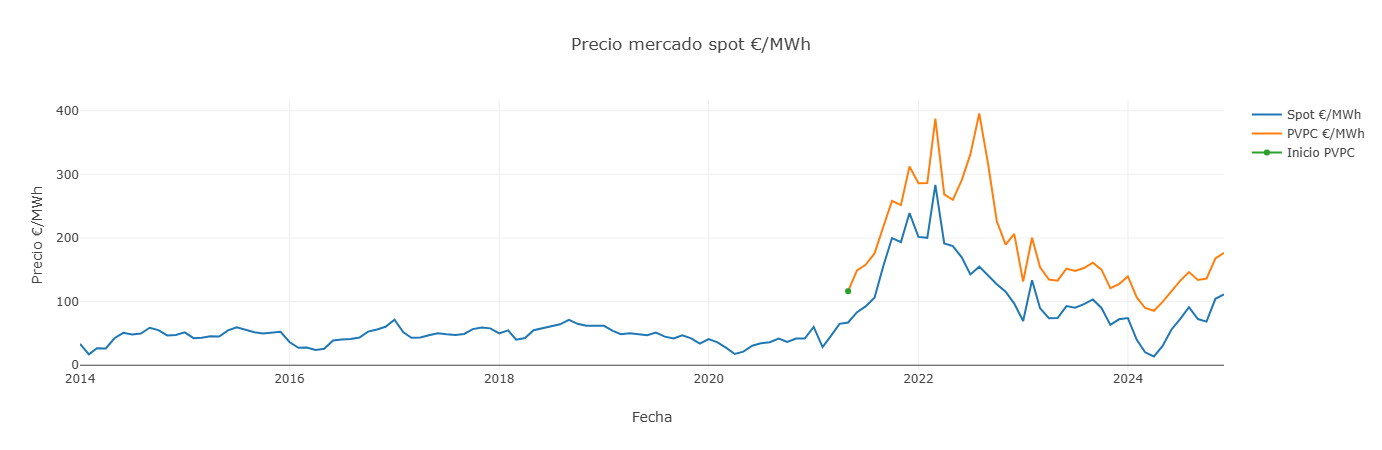

defined function precioHistoricoMensual
res4_1: String = "plot-ceba6eb5-ea16-4b24-aa87-d1e246384a59"

In [5]:
def precioHistoricoMensual = {
    val dfPromedioMensual = dataFrameMercados
        .withColumn("FechaMes", date_format(col("Fecha"), "yyyy-MM"))
        .groupBy(col("FechaMes"))
        .agg(avg("Valor_Mercado_Spot").as("PromedioSpotMes"),
             avg("PVPC_Valor").as("PromedioPVPCMes"))
        .orderBy(col("FechaMes"))
    
    // Filtrar filas con valores nulos en PromedioPVPCMes
    val dfPVPCFiltrado = dfPromedioMensual.filter(col("PromedioPVPCMes").isNotNull)
    
    val seqSpot = dfPromedioMensual.select("PromedioSpotMes").as[Double].collect.toSeq
    val seqPVPC = dfPVPCFiltrado.select("PromedioPVPCMes").as[Double].collect.toSeq
    val seqAñosSpot = dfPromedioMensual.select("FechaMes").as[String].collect.toSeq
    val seqAñosPVPC = dfPVPCFiltrado.select("FechaMes").as[String].collect.toSeq
    
    // Definir la fecha de inicio del PVPC
    val fechaInicioPVPC = "2021-05"
    val valorInicioPVPC = dfPVPCFiltrado.filter(col("FechaMes") === "2021-05").select("PromedioPVPCMes").as[Double].collect.toSeq // Valor ficticio para marcar el punto
    
    val traceSpot =  Scatter(seqAñosSpot, seqSpot, name = "Spot €/MWh")
    val tracePVPC = Scatter(seqAñosPVPC, seqPVPC, name = "PVPC €/MWh")
    val traceInicioPVPC = Scatter(Seq(fechaInicioPVPC), valorInicioPVPC, 
                                   name = "Inicio PVPC")
    
    val layout = Layout(title = "Precio mercado spot €/MWh",
                        xaxis = Axis(title = "Fecha"),
                        yaxis = Axis(title = "Precio €/MWh"))
    val data = Seq(traceSpot,tracePVPC,traceInicioPVPC)
    plot(data, layout)
}

precioHistoricoMensual

### Media precio por horas diario

In [3]:
def PrecioVsDemanda(dfMercados: DataFrame, dfDemanda: DataFrame, año: String) = {
    //Mercados
    val df = dfMercados
        .select("Valor_Mercado_Spot", "Fecha")
        .withColumn("Hora", date_format(col("Fecha"), "HH:00"))
        .groupBy(col("Hora"))
        .agg(avg("Valor_Mercado_Spot").as("PromedioPorHora"))
        .orderBy(col("Hora"))

    val seqPrecioEnergia = df.select("PromedioPorHora").as[Double].collect.toSeq
    //Demanda electrica
    val df2 = dfDemanda
        .select("Valor_programado", "Fecha")
        .withColumn("Hora", date_format(col("Fecha"), "HH:00"))
        .groupBy(col("Hora"))
        .agg(avg("Valor_programado").as("demandaProgramada"))
        .orderBy(col("Hora"))

    val seqDemandaProgramada = df2.select("demandaProgramada").as[Double].collect.toSeq
    
    val seqHoras = df.select("Hora").as[String].collect.toSeq

    val traceMercados =  Scatter(seqHoras, seqPrecioEnergia, name = "€/MWh")
    val traceDemanda =  Scatter(seqHoras, seqDemandaProgramada, name = "Demanda nacional en MWh", yaxis = AxisReference.Y2)
    
    val layout = Layout(title = "Mercado vs Demanda por horas en " + año,
                        xaxis = Axis(title = "Horas", dtick = 1),
                        yaxis = Axis(title = "Precio €/MWh"),
                        yaxis2 = Axis(
                              title = "Demanda MWh",
                              overlaying = AxisAnchor.Y, // Superponer sobre el eje Y principal
                              side = Side.Right // Posicionar en el lado derecho
                                ),
                        showlegend = true
                       )

    
    val data = Seq(traceMercados, traceDemanda)
    plot(data,layout)
}
//PrecioVsDemanda(datosMercados, datosDemanda)

defined function PrecioVsDemanda

collect at cmd2.sc:10

15 / 15

collect at cmd2.sc:10

200 / 200

collect at cmd2.sc:10

200 / 200

collect at cmd2.sc:10

24 / 24

collect at cmd2.sc:19

15 / 15

collect at cmd2.sc:19

200 / 200

collect at cmd2.sc:19

200 / 200

collect at cmd2.sc:19

24 / 24

collect at cmd2.sc:21

15 / 15

collect at cmd2.sc:21

200 / 200

collect at cmd2.sc:21

200 / 200

collect at cmd2.sc:21

24 / 24

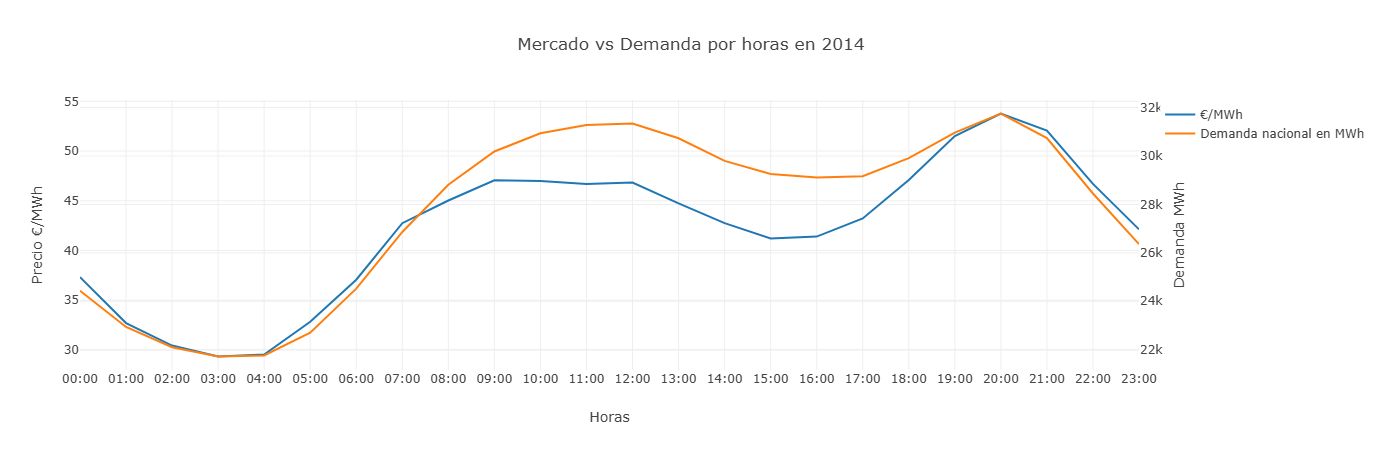

mercados2014: Dataset[Row] = [Fecha: timestamp, Valor_Mercado_Spot: double ... 3 more fields]
demanda2014: Dataset[Row] = [Fecha: timestamp, Valor_previsto: bigint ... 5 more fields]
res3_2: String = "plot-06ffc274-1f86-41e9-b31a-a0b2fd0f8c31"

In [4]:
val mercados2014 = datosMercados.filter(date_format(col("Fecha"), "yyyy") === "2014")
val demanda2014 = datosDemanda.filter(date_format(col("Fecha"), "yyyy") === "2014")
PrecioVsDemanda(mercados2014, demanda2014, "2014")

collect at cmd2.sc:10

15 / 15

collect at cmd2.sc:10

200 / 200

collect at cmd2.sc:10

200 / 200

collect at cmd2.sc:10

24 / 24

collect at cmd2.sc:19

15 / 15

collect at cmd2.sc:19

200 / 200

collect at cmd2.sc:19

200 / 200

collect at cmd2.sc:19

24 / 24

collect at cmd2.sc:21

15 / 15

collect at cmd2.sc:21

200 / 200

collect at cmd2.sc:21

200 / 200

collect at cmd2.sc:21

24 / 24

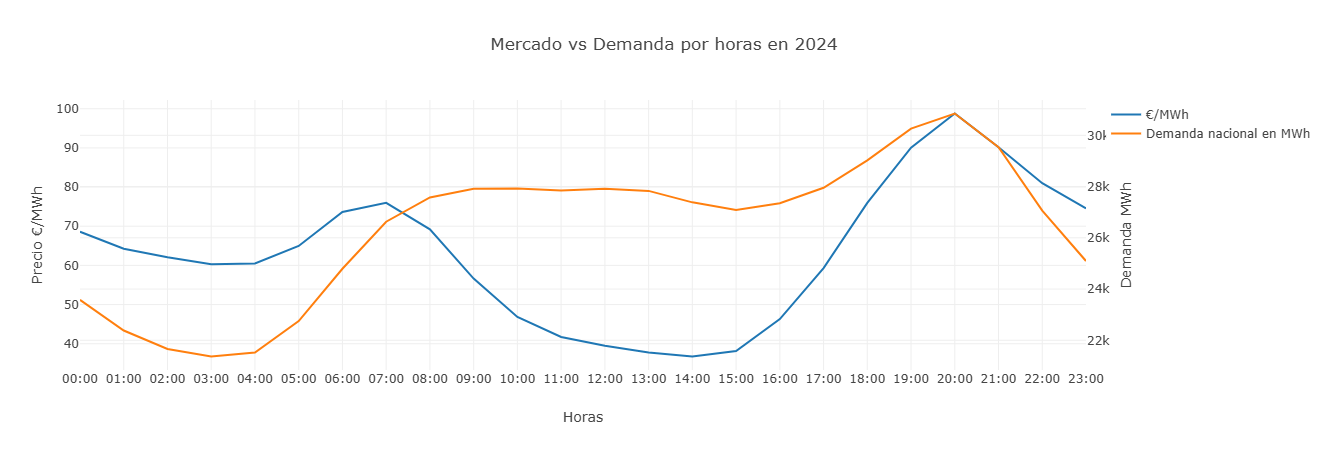

mercados2024: Dataset[Row] = [Fecha: timestamp, Valor_Mercado_Spot: double ... 3 more fields]
demanda2024: Dataset[Row] = [Fecha: timestamp, Valor_previsto: bigint ... 5 more fields]
res3_2: String = "plot-9f753adf-0c83-4cca-88d1-daa163ac8863"

In [4]:
val mercados2024 = datosMercados.filter(date_format(col("Fecha"), "yyyy") === "2024")
val demanda2024 = datosDemanda.filter(date_format(col("Fecha"), "yyyy") === "2024")
PrecioVsDemanda(mercados2024, demanda2024, "2024")

In [4]:
datosGeneracion.show()

cmd4.sc:1: not found: value datosGeneracion
val res4 = datosGeneracion.show()
           ^Compilation Failed

: 

In [ ]:
val mercados2024 = datosMercados.filter(date_format(col("Fecha"), "yyyy") === "2023")
val demanda2024 = datosDemanda.filter(date_format(col("Fecha"), "yyyy") === "2023")
PrecioVsDemanda(mercados2024, demanda2024, "2023")

collect at cmd2.sc:10

15 / 15

collect at cmd2.sc:10

200 / 200

collect at cmd2.sc:10

200 / 200

collect at cmd2.sc:10

24 / 24

collect at cmd2.sc:19

15 / 15

collect at cmd2.sc:19

200 / 200

collect at cmd2.sc:19

200 / 200

collect at cmd2.sc:19

24 / 24

collect at cmd2.sc:21

15 / 15

collect at cmd2.sc:21

200 / 200

collect at cmd2.sc:21 
 (kill)

8 + 18 / 200